# PacBio SGA Workflow
*Alec Pankow, Ben Murrell*

## description

A Julia notebook for generating consensus sequences from barcoded PacBio long read amplicon sequence data. 

In [1]:
# imports... 
using PacBioSGA
using NextGenSeqUtils
using StatsBase


## demultiplexing

Separate barcoded amplicons based on forward / reverse primer barcode information. Here we process a dataset of 28 HIV-1 *env* barcoded amplicons (HXB2 pos. XXX-XXXX). 

In [2]:
using CSV
using DataFrames

# read in primer sheet... 
meta = CSV.read("../data/LP157.tsv", DataFrame; stringtype = String);
head(meta)

,ID,fwd_primer,rev_primer,dataset
,String,String,String,String
1,FU_RU,GAGCAGAAGACAGTGGCAATGA,CCACTTGCCACCCATBTTATAGCA,LP157
2,FU_RA,GAGCAGAAGACAGTGGCAATGA,TCAGTCCACTTGCCACCCATBTTATAGCA,LP157
3,FU_RB,GAGCAGAAGACAGTGGCAATGA,TATGCCCACTTGCCACCCATBTTATAGCA,LP157
4,FU_RC,GAGCAGAAGACAGTGGCAATGA,ATACGCCACTTGCCACCCATBTTATAGCA,LP157
5,FU_RD,GAGCAGAAGACAGTGGCAATGA,CGTAGCCACTTGCCACCCATBTTATAGCA,LP157
6,FU_RE,GAGCAGAAGACAGTGGCAATGA,CTGCTCCACTTGCCACCCATBTTATAGCA,LP157


For efficient lookup, primers can be truncated to a unique substring, here 12 nt. Primers should be at least 2 nt 
apart to avoid collisions.  

In [3]:
# truncate and construct lookup dict
cut = 12
FWD_PRIMERS = [s[1:cut] for s in meta.fwd_primer]
REV_PRIMERS = [s[1:cut] for s in meta.rev_primer]
primer_dict = Dict(zip(zip(FWD_PRIMERS,REV_PRIMERS),meta.ID)); 

# check input primers for uniqueness...  
if length(primer_dict) != nrow(meta)
    @warn "Primer pairs are not unique. Check your primer configuration or increase primr length used for demux!"
end

# check input primers for distances... 
primer_vec = vcat(union(FWD_PRIMERS),union(REV_PRIMERS))
bad_pairs = []
for i in 1:length(primer_vec)
    for j in i+1:length(primer_vec)
        d = sum(collect(primer_vec[i]) .!= collect(primer_vec[j]))
        if d < 2
            push!(bad_pairs, (primer_vec[i], primer_vec[j], d))
        end
    end
end
if length(bad_pairs) > 0
    @warn "Primers within 1 NT (1st primer, 2nd primer, dist)\nCheck your cutoff distance and manifest!\n$(join((bad_pairs),'\n'))\n"
end

Functions from `NextGenSeqUtils.jl` are used to perform demultiplexing directly from the gzipped .FASTQ file. Addtional parameters for the max estimated error rate and read length are also applied here. 

In [4]:
mkdir("demux")

# additional arguments for demultiplexing... 
kwargs = [
    :error_rate => 0.02,
    :min_length => 500,
    :max_length => 12000,
    :primer_lookup => primer_dict,
    :demux_dir => "demux/",
    :fwd_primers => union(FWD_PRIMERS),
    :rev_primers => union(REV_PRIMERS),
    :tol_one_error => false
    ]

# run demux... 
@time chunked_fastq_apply(
    "../data/LP157.fastq.gz", 
    NextGenSeqUtils.chunked_fastq_filter_demux; 
    chunk_size = 1e4, 
    f_kwargs = kwargs
    );

 12.486265 seconds (15.57 M allocations: 2.305 GiB, 8.16% gc time)


## consensus 

To infer PCR template seqeunces, we call `reconstructReads()`, a function built on the `RobustAmpliconDenoising.jl` (RAD) package with three different reconstruction methods. 

1. `:RobustChoice`: The default method, which clusters RAD reconstructions, selects the most abundant for each cluster, and returns all which meet or exceed a specified fraction of reads (default 5%). No explicit recombination or chimera detection is employed.
2. `:RAD`: Return all RAD reconstructions. This can include 'real' template-related sequences likely generated by polymerase errors. No explicit recombination or chimera detection is employed. 
3. `:simple_consensus`. Cannot account for template mixtures. 

To call `reconstructReads()` we define a simple function which caps read depth to a reasonable value, removes primer sequences, and filters out sequences with large insertions or deletions. 

In [5]:
# generate reconstructed templates for a FASTQ file
function processFile(file::String, fwd_primer::String, rev_primer::String; depth = 1000, length_filter = (0.8, 1.2))
    seqID = replace(basename(file), ".fastq" => "")
    reads, _, _ = read_fastq(file)

    # min depth...
    if length(reads) < 3
        println("Insufficient read depth for $(seqID)!")
        return (String[],String[])
    end

    # cap sequencing depth... 
    if length(reads) > depth
        reads = reads[1:depth]
    end

    # trim primers... 
    reads = double_primer_trim.(reads, uppercase(fwd_primer), uppercase(rev_primer))

    ## length filter...
    if !isnothing(length_filter)
        ls = length.(reads)
        l = StatsBase.median(ls)
        keeps = (ls .>= length_filter[1]*l) .& (ls .<= length_filter[2]*l)
        reads = reads[keeps]
    end

    # reconstruct...
    denoised_seqs, denoised_names = reconstruct_reads(
        reads, 
        method = :RobustChoice, # one of :RobustChoice, :RAD, or :simple_consensus
        fine_radius = 1.0, # radius for RAD reconstruction
        robust_cluster_radius = 0.01, # radius for RobustChoice clustering
        RobustProportion = 0.05 # proportion threshold for RobustChoice
    )

    return denoised_seqs, seqID.*"_".*denoised_names
end

# path to demuxed .fastq files... 
dir = "demux"

# primers...
FWD_PRIMER = "NNNNNGAGCAGAAGACAGTGGCAATGA";
REV_PRIMER = "NNNNNCCACTTGCCACCCATBTTATAGCA";

# ignore unknown primer combinations...
files = [dir*"/"*f for f in readdir(dir) if f[end-5:end] == ".fastq" && !startswith(f,"UNKNOWN")]
println("Generating consensus for $(length(files)) .fastq files")

# iterate through FASTQ files
out_seqs, out_names = String[], String[]
for file in files
    denoised_seqs, denoised_names = processFile(file, FWD_PRIMER, REV_PRIMER)
    push!(out_seqs, denoised_seqs...)
    push!(out_names, denoised_names...)
end

write_fasta("LP157.fasta", out_seqs; names = out_names)


Generating consensus for 43 .fastq files


Insufficient read depth for F10_RC_AGAGTGAGCAGA_ATACGCCACTTG!


┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41
┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41


Insufficient read depth for F3_RA_TGCATGAGCAGA_TCAGTCCACTTG!


┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41


Insufficient read depth for F3_RU_TGCATGAGCAGA_CCACTTGCCACC!


Insufficient read depth for F4_RD_ATCTGGAGCAGA_CGTAGCCACTTG!


┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41
┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41
┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41
┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41


Insufficient read depth for F7_RU_CGTCAGAGCAGA_CCACTTGCCACC!


┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41
┌ Warning: Failed to reconstruct...
└ @ PacBioSGA /Users/appankow/.julia/dev/PacBioSGA/src/consensus.jl:41


## plotting utils

`digital_gel_plot()`

A 'digital gel' plot for read size distributions in each demultiplexed sample. 

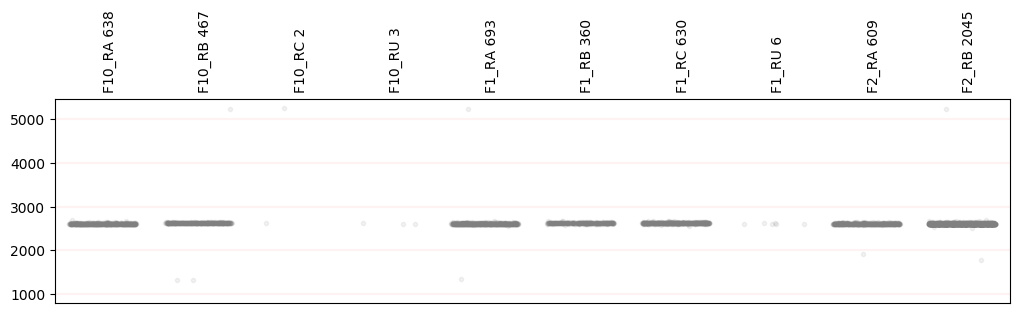

In [16]:
using PyPlot

# extract template name from file...
labels = [join(s[1:2], '_') for s in split.(basename.(files), '_')];

# plot digital gel...
n = 10
fig, ax = digital_gel_plot(files[1:n]; labels = labels[1:n], 
alpha = 0.1, height = 3, grid_lines_every = 1000);
fig


The plot can be altered and extended to with `PyPlot.jl` by manipulating the returned figure and axes objects. Here we tighten with y-axis limits for better resolution.

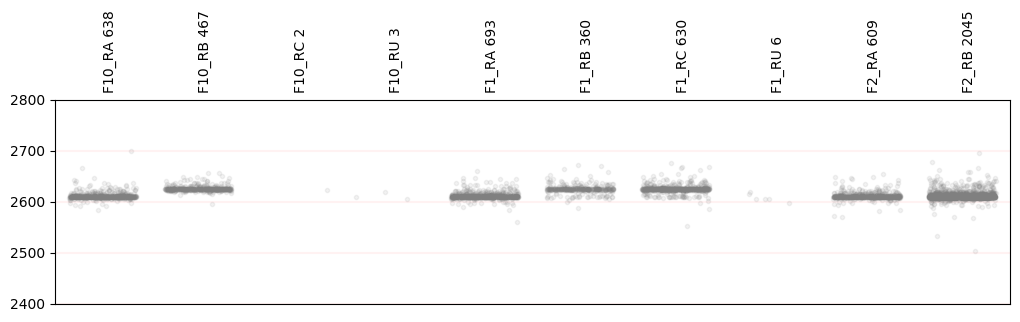

In [18]:
# plot digital gel...
n = 10
fig, ax = digital_gel_plot(files[1:n]; labels = labels[1:n], 
alpha = 0.1, height = 3, grid_lines_every = 100);
ax.set_ylim(2400,2800)
fig

`kmer_dist_mds_plot()`

A multidimensional scaling plot of pairwise corrected kmer distances (see RAD paper) for all read observations in a given sample. In the case below, two clear populations are visible, with unqiue errors accumulating in daughter molecules and a small number of recombinants (or PCR chimeras) that fall between the populations.  

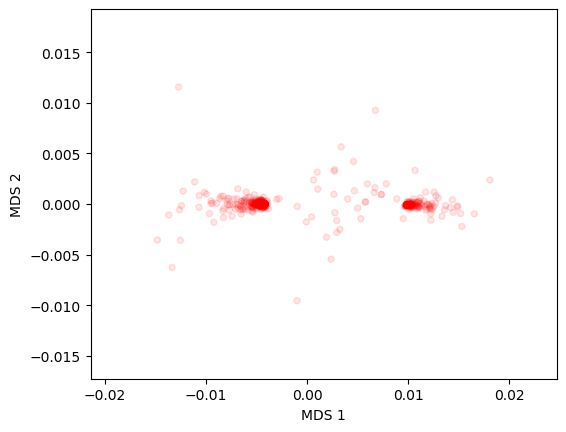

In [8]:
seqs, _, _ = read_fastq(files[18]);
seqs = double_primer_trim.(seqs, uppercase(FWD_PRIMER), uppercase(REV_PRIMER))

kwargs = [:c => "red", :sizes => 20*ones(length(seqs)), :alpha => 0.1]
fig, ax = kmer_dist_mds_plot(seqs; kwargs = kwargs);
ax.set_aspect("equal")
fig